# 1. Batch normalization (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

1. If your model didn't use batch normalization, add it. If it already had batch normalization, remove it. How does the performance change? Please experiment with different learning rate values, since batch normalization can allow a different range of learning rates to work. You are welcome to write your own batch norm implementaiton or use a pre-existing one from mxnet or pytorch.
1. Plot the squared L2 norm of gradients with respect to parameters over the course of training with and without batch normalization. To do this, you will need to compute the gradient of the loss over some data with respect to each parameter, square these gradients, and sum the result across all parameters. You can compute this value at each training step, or after each epoch. What difference does batch normalization make in terms of the squared L2 norm of gradients?

### 1.1 Batch Normalization Implementation

Since in the previous homework I showed the network with and without batch norm, to do something new, I derive the following implementation of batch norm:

In [1]:
### Import Dependencies

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Define the Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
### Download and Pre-Process the Data [BOILERPLATE]

'''
### Default Transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 ship   cat  ship   car
torch.Size([128, 3, 32, 32])


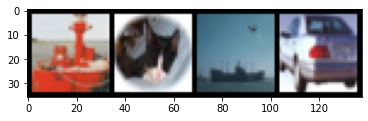

In [3]:
# Sample the Data to show an image [BOILERPLATE]

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print(images.shape)

In [4]:
def calc_test_loss(model, data_loader, criterion, device):
    with torch.no_grad():
        _, labels = next(iter(data_loader))
        batch_size = len(labels)
        running_loss = 0
        for inps, labels in data_loader:
            inps = inps.to(device)
            labels = labels.to(device)
            touts = model(inps)
            tloss = criterion(touts, labels)
            running_loss += tloss.item()
        return running_loss / len(data_loader)

def calc_test_accuracy(model, test_loader, device):
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

In [5]:
def plot_training_curves(train_loss, test_loss, model_name):
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['Train', 'Test'])
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training Graph: ' + model_name)
    plt.show()

In [6]:
def train_epochs(n_epochs, train_loader, test_loader, model, optimizer, criterion, log_every=1000, dev=device):
    # See how often to log iterations
    if log_every <= len(train_loader): # Check for log_every is equal to at least 1 epoch
        if log_every >= 1:             
            log_every = log_every
    else:
        log_every = len(train_loader) # Default to 1 epoch's n_iters
    
    train_loss = []
    test_loss = []
    grad_l2 = []

    for epoch in range(n_epochs):  
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(dev), labels.to(dev)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % log_every == log_every - 1:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / log_every))
                train_loss += [running_loss / log_every]
                test_loss += [calc_test_loss(model, test_loader, criterion, dev)]
                running_loss = 0.0
                grad_l2 += [sum([torch.norm(value.grad).item()**2 for param, value in list(model.named_parameters())])]

    print('Finished Training')
    return model, train_loss, test_loss, grad_l2

#### Baseline Model with No Batch Norm

In [7]:
class VanillaConvStem(nn.Module):
    def __init__(self, spec, bnorm):
        super(VanillaConvStem, self).__init__()
        layers = self._make_net(spec, bnorm)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        y = self.net(x)
        return y

    def _make_net(self, spec, bnorm):
        # specs = [(kernel, stride, padding, in_channels, out_channels)]
        layers = []
        kernel, stride, padding, in_channels, out_channels = spec
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel, 
                                    stride=stride, padding=padding, bias=False))
        if bnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        layers.append(nn.ReLU())
        return layers

In [8]:
class ConvBlock1(nn.Module):
    def __init__(self, spec, bnorm):
        super(ConvBlock1, self).__init__()
        layers = self._make_block(spec, bnorm)
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        y = self.net(x)
        return y
    
    def _make_block(self, spec, bnorm):
        # layer_specs = [(kernel, stride, padding, in_channels, out_channels)]
        
        layers = []
        kernel, stride, padding, in_channels, out_channels = spec
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        if bnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        if bnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

        return layers   

In [9]:
class NNBody(nn.Module):
    def __init__(self, blocks):
        super(NNBody, self).__init__()
        blocks += [nn.Flatten()]
        self.net = nn.Sequential(*blocks)

    def forward(self, x):
        y = self.net(x)
        return y

In [10]:
class VanillaDenseHead(nn.Module):
    def __init__(self, out_dims, num_classes, dropout):
        super(VanillaDenseHead, self).__init__()
        layers = self._make_net(out_dims, num_classes, dropout)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        y = self.net(x)
        return y

    def _make_net(self, out_dims, num_classes, dropout):
        layers = []
        for out_dim in out_dims:
            layers.append(nn.LazyLinear(out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(out_dim, num_classes)) 
        return layers

In [11]:
class BaselineNet(nn.Module):
    def __init__(self, arch):
        '''Arch is a dictionary of layer specs'''
        super(BaselineNet, self).__init__()
        self.stem = arch['stem']
        self.body = arch['body']
        self.head = arch['head']
        total_layers = [self.stem, self.body, self.head]
        self.net = nn.Sequential(*total_layers)

    def forward(self, x):
        y = self.net(x)
        return y

In [25]:
unnormed_arch = {
    'stem': VanillaConvStem((5, 2, 3, 3, 16), bnorm=False),
    'body': NNBody([ConvBlock1((3, 1, 1, 16, 32),bnorm=False),
            ConvBlock1((3, 1, 1, 32, 64), bnorm=False),
            ConvBlock1((3, 1, 1, 64, 64), bnorm=False)
            ]),
    'head': VanillaDenseHead([512, 128, 32], num_classes=10, dropout=0.25)
        }

In [26]:
def warmup_model(model, sample_input, device=device):
    loaded_model =  model.to(device)
    inps = sample_input.to(device)
    loaded_model(inps)

In [27]:
bNet = BaselineNet(unnormed_arch).to(device)
warmup_model(bNet, images)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bNet.parameters(), lr=.01, momentum=0.9)
opt_base, tr_loss, tst_loss, grads = train_epochs(10, trainloader, testloader, bNet, optimizer, criterion, log_every=250)

[1,   250] loss: 2.304
[2,   250] loss: 2.303
[3,   250] loss: 2.303
[4,   250] loss: 2.303
[5,   250] loss: 2.303
[6,   250] loss: 2.303
[7,   250] loss: 2.303
[8,   250] loss: 2.303
[9,   250] loss: 2.303
[10,   250] loss: 2.303
Finished Training


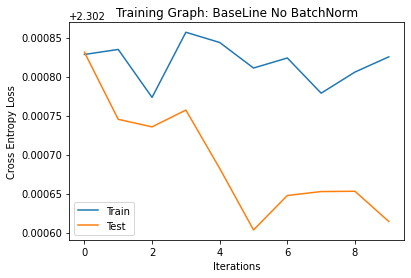

In [ ]:
plot_training_curves(tr_loss, tst_loss, 'BaseLine No BatchNorm')

In [20]:
normed_arch = {
    'stem': VanillaConvStem((5, 2, 3, 3, 16), bnorm=True),
    'body': NNBody([ConvBlock1((3, 1, 1, 16, 32),bnorm=True),
            ConvBlock1((3, 1, 1, 32, 64), bnorm=True),
            ConvBlock1((3, 1, 1, 64, 64), bnorm=True)
            ]),
    'head': VanillaDenseHead([512, 128, 32], num_classes=10, dropout=0.25)
        }

bNet2 = BaselineNet(normed_arch).to(device)
warmup_model(bNet2, images)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bNet2.parameters(), lr=.01, momentum=0.9)

In [21]:
opt_bn, tr_loss, tst_loss, normed_grads = train_epochs(10, trainloader, testloader, bNet2, optimizer, criterion, log_every=250)

[1,   250] loss: 1.884
[2,   250] loss: 1.375
[3,   250] loss: 1.185
[4,   250] loss: 1.056
[5,   250] loss: 0.959
[6,   250] loss: 0.887
[7,   250] loss: 0.811
[8,   250] loss: 0.758
[9,   250] loss: 0.700
[10,   250] loss: 0.658
Finished Training


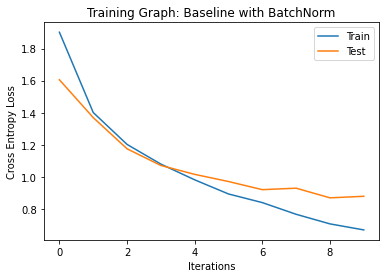

In [ ]:
plot_training_curves(tr_loss, tst_loss, 'Baseline with BatchNorm')

**Written Answer for Pt1:**:

As we can see from the above, the inclusion of batch norm results in a much more stable training at the given learning rate. I also tried modulating the learning rate by factors of 10 and we can clearly see that it is unstable without batch normalization. Across learning rates of [1, .01, and .001] only the network with batch norm was able to keep pushing loss down on the training set, althougt at eta=1 the BN net reported nan for the loss. The training curves would sometimes diverge for high values of eta without batch norm but this wasn't the case with the learning rates trialed.

#### 1.2 Squared L2 Norms of the Gradients

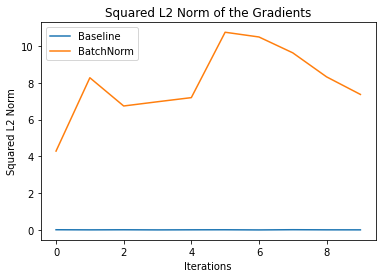

In [ ]:
plt.plot(grads)
plt.plot(normed_grads)
plt.title('Squared L2 Norm of the Gradients')
plt.xlabel('Iterations')
plt.ylabel('Squared L2 Norm')
plt.legend(['Baseline', 'BatchNorm'])
plt.show()

**Written Asnwer for Pt2**:
As we can see from the plot of the L2 norm, the L2-norm of the gradients are much larger in the case of the batch norm than without. This result agrees with the printed loss that was output at the end of every epoch where the loss was barely changing for the model with no batch norm until the end. Interestingly, although it looks like the model should have been trained further, when I ran the model for 20 epochs, it only dropped in loss after epoch 17/18 and remained in a plateau before. I am curious if there is some learning rate scheduler that is implicitly called in the optimizer code that is responsible for this since I don't believe that momentum (unlike Adam) explicitly includes the timestep t as a variable in its calculation.

# 2. Residual connections (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

If your model didn't use residual connections, add them. If it already had residual connections, remove them. How does the performance change? Please experiment with applying residual connections around different blocks, where a block is a subset of layers (for example, add a residual connection around a single convolution/nonlinearity combination, or a residual connection around two convolution/nonlinearity combinations). Note that you may need to add 1x1 convolutions in the residual path if your block changes the shape (spatial or number of channels) of the input.

In [13]:
class ConvBlock2(nn.Module):
    def __init__(self, spec, bnorm):
        super(ConvBlock2, self).__init__()
        layers = self._make_block(spec, bnorm)
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        y = self.net(x)
        return y
    
    def _make_block(self, spec, bnorm):
        # layer_specs = [(kernel, stride, padding, in_channels, out_channels)]
        
        layers = []
        kernel, stride, padding, in_channels, out_channels = spec
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        if bnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        if bnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        # layers.append(nn.ReLU()) Taken out for Residual ReLU operation
        return layers   

In [14]:
class ConvBlock3(nn.Module):
    def __init__(self, spec, bnorm):
        super(ConvBlock3, self).__init__()
        layers = self._make_block(spec, bnorm)
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        y = self.net(x)
        return y
    
    def _make_block(self, spec, bnorm):
        # layer_specs = [(kernel, stride, padding, in_channels, out_channels)]
        
        layers = []
        kernel, stride, padding, in_channels, out_channels = spec
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        if bnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        return layers  

In [15]:
class ConvResBlock(nn.Module):
    def __init__(self, core):
        super(ConvResBlock, self).__init__() 
        self.device = device
        self.core = core
    
    def forward(self, x):
        y = self.core(x)
        try:
            y += x
        except:
            add_conv = nn.Conv2d(x.shape[1], y.shape[1], kernel_size=1).to(x.device)
            y+= add_conv(x)
        return F.relu(y)

In [22]:
res_arch1 = {
    'stem': VanillaConvStem((5, 2, 3, 3, 16), bnorm=True),
    'body': NNBody([ConvResBlock(ConvBlock2((3, 1, 1, 16, 32),bnorm=True)),
            ConvResBlock(ConvBlock2((3, 1, 1, 32, 64), bnorm=True)),
            ConvResBlock(ConvBlock2((3, 1, 1, 64, 64), bnorm=True))
            ]),
    'head': VanillaDenseHead([512, 128, 32], num_classes=10, dropout=0.25)
        }
        
ConvResNet1 = BaselineNet(res_arch1).to(device)
warmup_model(ConvResNet1, images)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ConvResNet1.parameters(), lr=.01, momentum=0.9)

In [23]:
opt_resnet, tr_loss, tst_loss, resnet_grads = train_epochs(10, trainloader, testloader, ConvResNet1, optimizer, criterion, log_every=250)

[1,   250] loss: 1.890
[2,   250] loss: 1.425
[3,   250] loss: 1.255
[4,   250] loss: 1.129
[5,   250] loss: 1.047
[6,   250] loss: 0.971
[7,   250] loss: 0.891
[8,   250] loss: 0.852
[9,   250] loss: 0.795
[10,   250] loss: 0.753
Finished Training


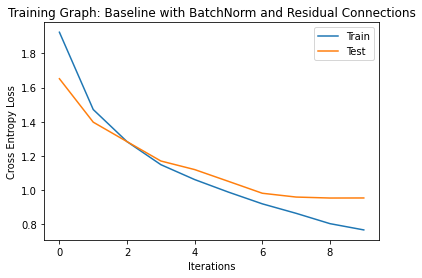

In [ ]:
plot_training_curves(tr_loss, tst_loss, 'Baseline with BatchNorm and Deep Residual Connections')

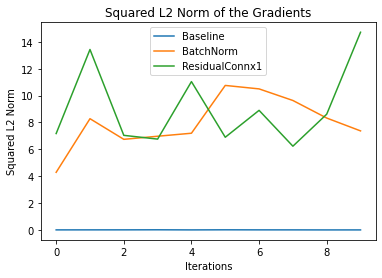

In [ ]:
plt.plot(grads)
plt.plot(normed_grads)
plt.plot(resnet_grads)
plt.title('Squared L2 Norm of the Gradients')
plt.xlabel('Iterations')
plt.ylabel('Squared L2 Norm')
plt.legend(['Baseline', 'BatchNorm', 'ResidualConnx1'])
plt.show()

In [16]:
### Very shallow residual connections

res_arch2 = {
    'stem': VanillaConvStem((5, 2, 3, 3, 16), bnorm=True),
    'body': NNBody([ConvResBlock(ConvBlock3((3, 1, 1, 16, 32),bnorm=True)),
                    ConvResBlock(ConvBlock3((3, 1, 1, 32, 32),bnorm=True)), # Added to maintain depth
                    ConvResBlock(ConvBlock3((3, 1, 1, 32, 64), bnorm=True)),
                    ConvResBlock(ConvBlock3((3, 1, 1, 64, 64),bnorm=True)), # Added to maintain depth
                    ConvResBlock(ConvBlock3((3, 1, 1, 64, 64), bnorm=True))
            ]),
    'head': VanillaDenseHead([512, 128, 32], num_classes=10, dropout=0.25)
        }
ConvResNet2 = BaselineNet(res_arch2).to(device)
warmup_model(ConvResNet2, images)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ConvResNet2.parameters(), lr=.01, momentum=0.9)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
opt_resnet2, tr_loss, tst_loss, resnet2_grads = train_epochs(10, trainloader, testloader, ConvResNet2, optimizer, criterion, log_every=250)

[1,   250] loss: 1.929
[2,   250] loss: 1.505
[3,   250] loss: 1.345
[4,   250] loss: 1.214
[5,   250] loss: 1.100
[6,   250] loss: 1.005
[7,   250] loss: 0.943
[8,   250] loss: 0.866
[9,   250] loss: 0.816
[10,   250] loss: 0.756
Finished Training


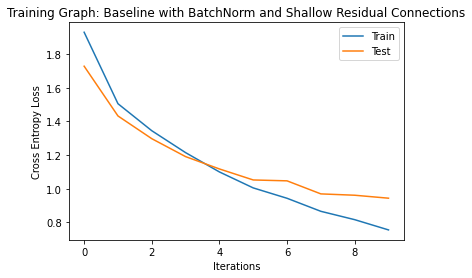

In [18]:
plot_training_curves(tr_loss, tst_loss, 'Baseline with BatchNorm and Shallow Residual Connections')

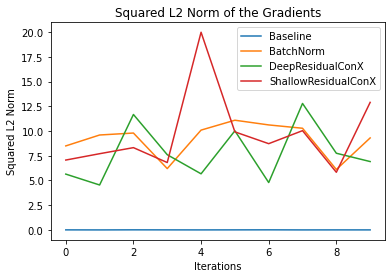

In [28]:
plt.plot(grads)
plt.plot(normed_grads)
plt.plot(resnet_grads)
plt.plot(resnet2_grads)
plt.title('Squared L2 Norm of the Gradients')
plt.xlabel('Iterations')
plt.ylabel('Squared L2 Norm')
plt.legend(['Baseline', 'BatchNorm', 'DeepResidualConX', 'ShallowResidualConX'])
plt.show()

In [30]:
calc_test_accuracy(opt_base, testloader, device=device)

Accuracy of the network on the test images: 9 %


In [31]:
calc_test_accuracy(opt_bn, testloader, device=device)

Accuracy of the network on the test images: 72 %


In [33]:
calc_test_accuracy(opt_resnet, testloader, device=device)


Accuracy of the network on the test images: 71 %


In [34]:
calc_test_accuracy(opt_resnet2, testloader, device=device)

Accuracy of the network on the test images: 69 %


In [38]:
res_arch3 = {
    'stem': VanillaConvStem((5, 2, 3, 3, 16), bnorm=True),
    'body': NNBody([
                
                ConvResBlock(nn.Sequential(ConvBlock2((3, 1, 1, 16, 32),bnorm=True),
                ConvBlock2((3, 1, 1, 32, 64), bnorm=True),
                ConvBlock2((3, 1, 1, 64, 64), bnorm=True)))

        ]),
    'head': VanillaDenseHead([512, 128, 32], num_classes=10, dropout=0.25)
        }
        
ConvResNet3 = BaselineNet(res_arch3).to(device)
warmup_model(ConvResNet3, images)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ConvResNet3.parameters(), lr=.01, momentum=0.9)

In [37]:
opt_resnet3, tr_loss, tst_loss, resnet3_grads = train_epochs(10, trainloader, testloader, ConvResNet3, optimizer, criterion, log_every=250)

[1,   250] loss: 1.905
[2,   250] loss: 1.372
[3,   250] loss: 1.177
[4,   250] loss: 1.058
[5,   250] loss: 0.977
[6,   250] loss: 0.898
[7,   250] loss: 0.844
[8,   250] loss: 0.787
[9,   250] loss: 0.739
[10,   250] loss: 0.695
Finished Training


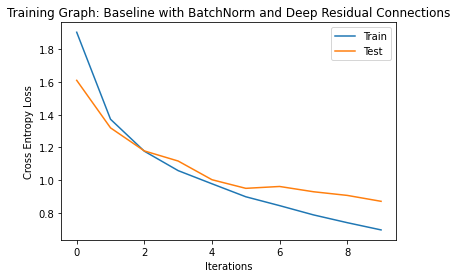

In [39]:
plot_training_curves(tr_loss, tst_loss, 'Baseline with BatchNorm and Deep Residual Connections')

In [40]:
calc_test_accuracy(opt_resnet3, testloader, device=device)

Accuracy of the network on the test images: 72 %


**Written Answer:** The inclusion of residual networks did not result in a significant boost to the prediction accuracy or the gradients at each time step. The first resnet wrapped a residual connection around the previous batchnorm convolution blocks and this resulted in three residual blocks each containing two convolutional filters. This resulted in a slight decrease compared to the convolutionals with batch norm alone. In order to explore whether or nor the depth of the residual connection played an impact in the performance of the resnet, I devised three architectures:

1. Shallow Residual Connections: Each residual block contained only one convolutional layer and batchnorm layer
2. Deep Residual Connections: The entire model was compressed into one block and a residual connection was passed around it 
3. Standard Residual Connection: This was the residual connections discussed in the paragraph above which was adding a residual connection to each convolutional block containing two ConvLayers.

As we can see from the performances, the shallow residual connections scored 69% accuracy on the test set, the deep residual connections scored 72% and the standard residual connection scored 71%. From here we might conclude that the deep residual connection is the best, however the fact that the deep residual connection scored the same as the model with no residual connections at all may be an indicator that the residual connection learned the identity function and is not impacting the calculation in any way. Thus we cannot say for certain if the deep connection is better than the standard connection but we can conclude that the standard connection is likely better than the shallow connections.